In [53]:
import rioxarray as rxr
import geopandas as gpd
import pandas as pd
import numpy as np
import requests
import tempfile
import os
from shapely.geometry import Point


Note that these paths may change as we tear down and recalculate burn metrics through development:

In [54]:
RBR_URL = "https://burn-severity-backend.s3.us-east-2.amazonaws.com/public/dse/Dome_Shp/rbr.tif"
DNBR_URL = "https://burn-severity-backend.s3.us-east-2.amazonaws.com/public/dse/Dome_Shp/dnbr.tif"
BOUNDARY_URL = "https://burn-severity-backend.s3.us-east-2.amazonaws.com/public/dse/Dome_Shp/boundary.geojson"


In [55]:
with tempfile.TemporaryDirectory() as temp_dir:
    # RBR
    RBR_PATH = os.path.join(temp_dir, "rbr.tif")
    r = requests.get(RBR_URL, allow_redirects=True)
    open(RBR_PATH, "wb").write(r.content)
    rbr = rxr.open_rasterio(RBR_PATH, masked=True).squeeze()

    # dNBR
    DNBR_PATH = os.path.join(temp_dir, "dnbr.tif")
    r = requests.get(DNBR_URL, allow_redirects=True)
    open(DNBR_PATH, "wb").write(r.content)
    dnbr = rxr.open_rasterio(DNBR_PATH, masked=True).squeeze()

    # Geojson of the fire perimeter
    BOUNDARY_PATH = os.path.join(temp_dir, "boundary.geojson")
    r = requests.get(BOUNDARY_URL, allow_redirects=True)
    open(BOUNDARY_PATH, "wb").write(r.content)
    boundary = gpd.read_file(BOUNDARY_PATH)

    


In [56]:
rbr

<xarray.DataArray (y: 838, x: 978)>
[819564 values with dtype=float64]
Coordinates:
    band         int64 1
  * x            (x) float64 -115.7 -115.7 -115.7 ... -115.5 -115.5 -115.5
  * y            (y) float64 35.39 35.39 35.39 35.39 ... 35.22 35.22 35.22 35.22
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      stackstac-3b798e04eadf348528a9721055dd1586

In [57]:
dnbr

<xarray.DataArray (y: 838, x: 978)>
[819564 values with dtype=float64]
Coordinates:
    band         int64 1
  * x            (x) float64 -115.7 -115.7 -115.7 ... -115.5 -115.5 -115.5
  * y            (y) float64 35.39 35.39 35.39 35.39 ... 35.22 35.22 35.22 35.22
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      stackstac-3b798e04eadf348528a9721055dd1586

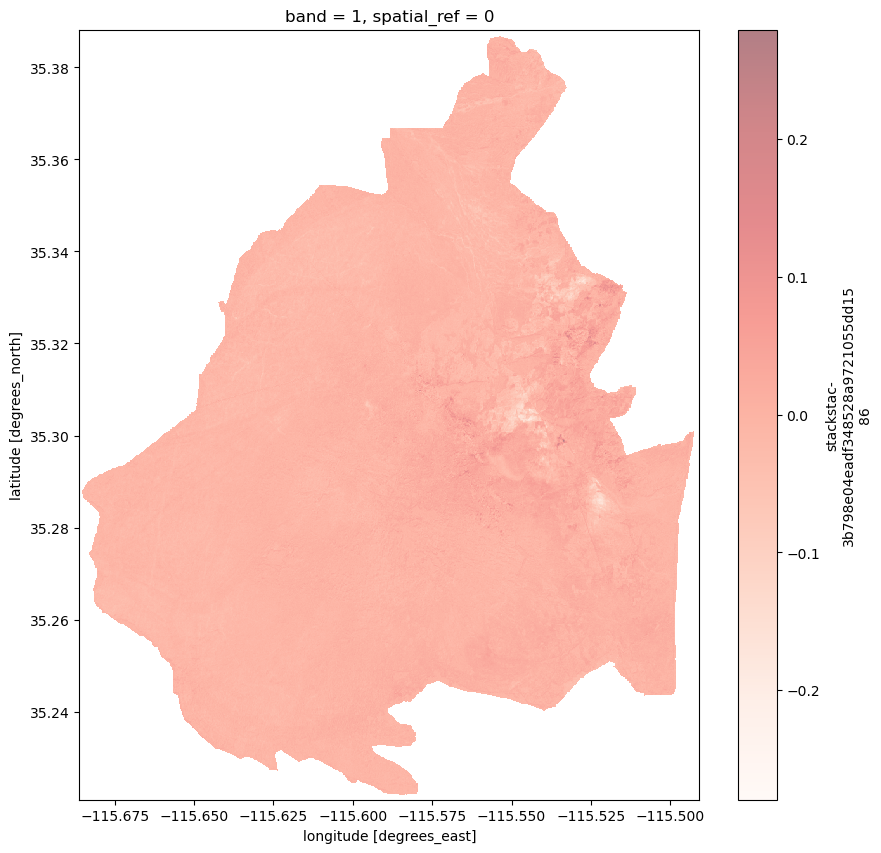

In [58]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# # Plot the boundary
# boundary.plot(ax=ax)

# Plot the rbr dataArray
rbr.rio.reproject("EPSG:4326").plot.imshow(ax=ax, cmap='Reds', alpha=0.5)

# # Plot the dnbr dataArray
# dnbr.rio.reproject("EPSG:4326").plot.imshow(ax=ax, cmap='Blues', alpha=0.5)

plt.show()


<Axes: >

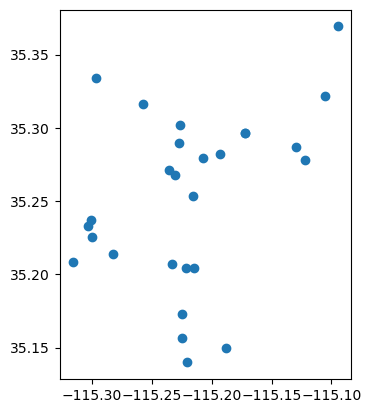

In [59]:
df = pd.read_csv('202308_YorkSeverityObservationPoints.csv')
df['geometry'] = df.apply(lambda row: Point(row.Longitude, row.Latitude), axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.crs = 'EPSG:4326'

gdf.plot()

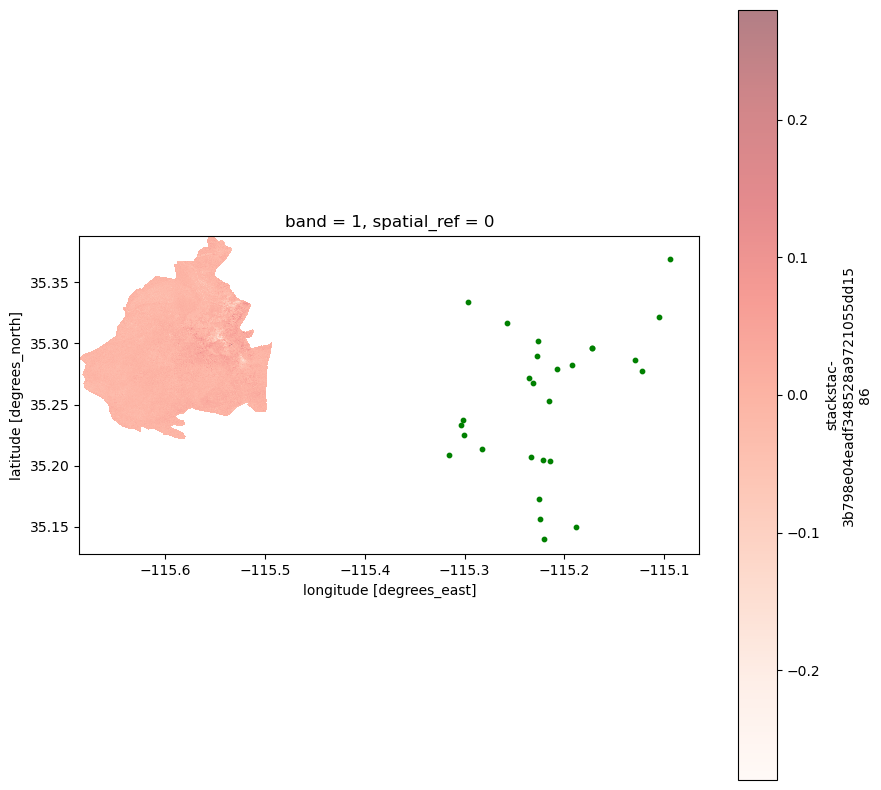

In [60]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the rbr dataArray
rbr.rio.reproject("EPSG:4326").plot.imshow(ax=ax, cmap='Reds', alpha=0.5)


# Plot the gdf points
gdf.plot(ax=ax, color='green', markersize=10)

plt.show()


In [61]:
geometry = [Point(xy) for xy in zip(rbr.x.values, rbr.y.values)]
rbr_gdf = gpd.GeoDataFrame(geometry=geometry)
rbr_gdf.crs = 'EPSG:4326'

rbr_gdf.to_crs('EPSG:32610', inplace=True) # for approximate distance in meters
gdf.to_crs('EPSG:32610', inplace=True) # for approximate distance in meters


In [63]:
approx_distance = rbr_gdf.distance(gdf.geometry).mean()
approx_distance

/tmp/ipykernel_43129/1981126062.py:1: UserWarning: The indices of the two GeoSeries are different.
  distance = rbr_gdf.distance(gdf.geometry).mean()


45485.47631030453